In [18]:
# Install required packages
%pip install -U tensorflow pillow scipy matplotlib seaborn scikit-learn

   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ----- ---------------------------------- 1.3/8.9 MB 8.4 MB/s eta 0:00:01
   ------------ --------------------------- 2.9/8.9 MB 7.0 MB/s eta 0:00:01
   ----------------- ---------------------- 3.9/8.9 MB 6.7 MB/s eta 0:00:01
   --------------------- ------------------ 4.7/8.9 MB 6.1 MB/s eta 0:00:01
   ---------------------------- ----------- 6.3/8.9 MB 5.9 MB/s eta 0:00:01
   ---------------------------------- ----- 7.6/8.9 MB 6.1 MB/s eta 0:00:01
   ---------------------------------------- 8.9/8.9 MB 6.1 MB/s  0:00:01
   ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
   ----- ---------------------------------- 1.6/11.3 MB 7.6 MB/s eta 0:00:02
   ------------ --------------------------- 3.4/11.3 MB 8.4 MB/s eta 0:00:01
   ----------------- ---------------------- 5.0/11.3 MB 8.2 MB/s eta 0:00:01
   ------------------- -------------------- 5.5/11.3 MB 6.8 MB/s eta 0:00:01
   ---------------------

In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image, ImageFile
from tensorflow.keras import layers, models

# Allow truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
from pathlib import Path

# Workspace dataset paths (update if needed)
BASE_DIR = Path(r'c:\Users\USER\Downloads\Bone Fractrure')
train_dir = BASE_DIR / 'Dataset' / 'training'
test_dir = BASE_DIR / 'Dataset' / 'testing'

# Image parameters
BATCH_SIZE = 32
IMG_HEIGHT = 180
IMG_WIDTH = 180

# Basic checks
assert train_dir.exists(), f"Training directory not found: {train_dir}"
assert test_dir.exists(), f"Testing directory not found: {test_dir}"

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation + normalization with validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)
val_gen = val_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 7091 images belonging to 2 classes.
Found 1772 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


#### model architecture

In [4]:
# Clear, well-structured CNN using Functional API
inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs=inputs, outputs=outputs, name='Simple_CNN')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "Simple_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,023,361 (30.61 MB)

 Trainable params: 8,023,361 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

### Train 

In [5]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

Epoch 1/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 93s 414ms/step - accuracy: 0.5982 - loss: 0.6540 - val_accuracy: 0.5852 - val_loss: 0.6877
Epoch 2/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 88s 398ms/step - accuracy: 0.6740 - loss: 0.5930 - val_accuracy: 0.4814 - val_loss: 0.7913
Epoch 3/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 87s 393ms/step - accuracy: 0.7460 - loss: 0.5225 - val_accuracy: 0.4622 - val_loss: 0.9627
Epoch 4/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 88s 393ms/step - accuracy: 0.7825 - loss: 0.4575 - val_accuracy: 0.4582 - val_loss: 1.0386
Epoch 5/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 88s 394ms/step - accuracy: 0.8193 - loss: 0.4020 - val_accuracy: 0.4509 - val_loss: 1.1651
Epoch 6/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 87s 392ms/step - accuracy: 0.8484 - loss: 0.3547 - val_accuracy: 0.4137 - val_loss: 1.2989
Epoch 7/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 87s 391ms/step - accuracy: 0.8724 - loss: 0.3039 - val_accuracy: 0.4148 - val_loss: 1.4465
Epoch 8/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 87s 393ms/step - accuracy: 0.8875 - loss: 0

### Accuracy & Loss Visualization

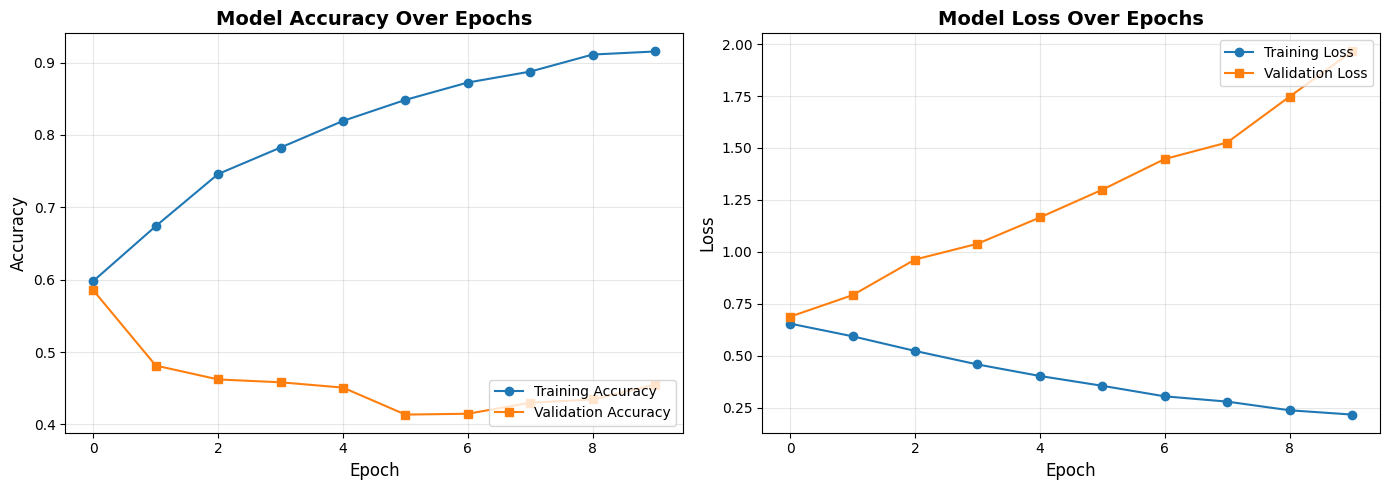


=== Training Summary ===
Final Training Accuracy: 0.9152
Final Validation Accuracy: 0.4549
Final Training Loss: 0.2162
Final Validation Loss: 1.9643


In [6]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
print("\n=== Training Summary ===")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

### Test

In [7]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.2f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.5733 - loss: 0.9284
Test Accuracy: 0.57
Test Loss: 0.93


### Detailed Evaluation Metrics

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step


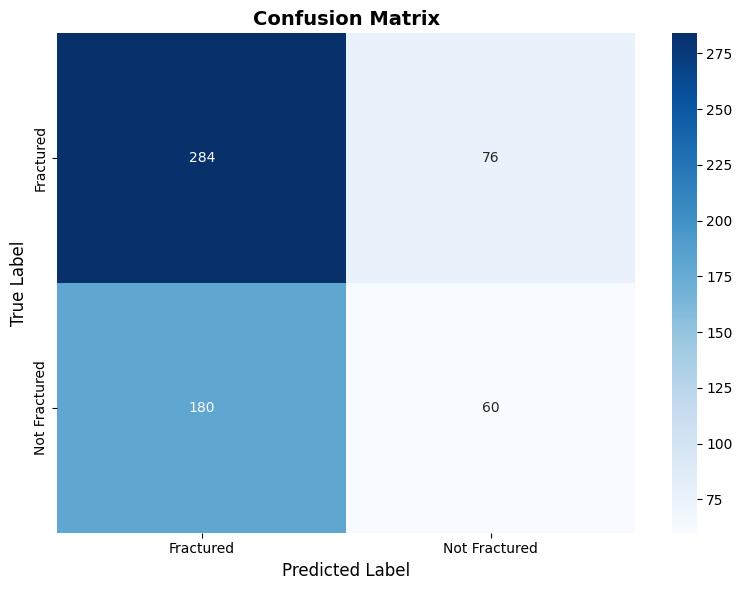


=== Classification Report ===
               precision    recall  f1-score   support

    Fractured       0.61      0.79      0.69       360
Not Fractured       0.44      0.25      0.32       240

     accuracy                           0.57       600
    macro avg       0.53      0.52      0.50       600
 weighted avg       0.54      0.57      0.54       600



In [8]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

# Get predictions
test_gen.reset()
predictions = model.predict(test_gen, steps=len(test_gen))
predicted_classes = (predictions > 0.5).astype(int).flatten()
true_classes = test_gen.classes

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fractured', 'Not Fractured'],
            yticklabels=['Fractured', 'Not Fractured'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Classification Report
print("\n=== Classification Report ===")
print(classification_report(true_classes, predicted_classes, 
                          target_names=['Fractured', 'Not Fractured']))

### Save Model


In [9]:
model.save('fracture_classification_model.keras')

In [14]:
loaded_model = tf.keras.models.load_model('fracture_classification_model.keras')

c:\Users\USER\Downloads\Bone Fractrure\.venv\lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Custom Image


In [12]:
# Detect fracture from a user-selected image using the saved model
import tkinter as tk
from tkinter import filedialog
from PIL import Image
import numpy as np

# Load the trained model
model = tf.keras.models.load_model('fracture_classification_model.keras')

# Open file dialog to select an image
root = tk.Tk()
root.withdraw()  # Hide the main window
file_path = filedialog.askopenfilename(title='Select X-ray Image', filetypes=[('Image Files', '*.png;*.jpg;*.jpeg')])

if file_path:
    # Load and preprocess the image
    img = Image.open(file_path).convert('RGB')
    img = img.resize((IMG_WIDTH, IMG_HEIGHT))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict fracture
    prediction = model.predict(img_array)[0][0]
    if prediction > 0.5:
        print(f"Prediction: Not Fractured (Confidence: {prediction:.2f})")
    else:
        print(f"Prediction: Fractured (Confidence: {1-prediction:.2f})")
else:
    print('No image selected.')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Prediction: Not Fractured (Confidence: 0.92)


In [6]:
# Professional X-ray themed GUI with customtkinter (light color scheme, responsive scaling)
from customtkinter import *
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk, ImageFile
import numpy as np
import tensorflow as tf

# X-ray inspired color palette (light, clinical, blue/cyan/white)
CLR_BG = "#F6F8FB"         # X-ray film white
CLR_CARD = "#E3F0FF"       # Soft blue card
CLR_ACCENT = "#00B4D8"     # X-ray cyan
CLR_ACCENT2 = "#48CAE4"    # Lighter cyan
CLR_TEXT = "#222831"       # Deep gray text
CLR_SUBTLE = "#B0BEC5"     # Subtle gray
CLR_DANGER = "#FF6B6B"     # Alert red
CLR_SUCCESS = "#43D19E"    # Green for negative
CLR_WARNING = "#FFD166"    # Amber for highlights

set_appearance_mode("light")

IMG_SIZE = (180, 180)
MODEL_PATH = 'fracture_classification_model.keras'

# Dataset details (actual counts from Dataset/training and Dataset/testing)
TRAIN_TOTAL = 8863
TRAIN_FRACTURED = 4480
TRAIN_NOT_FRACTURED = 4383
TEST_TOTAL = 600
TEST_FRACTURED = 360
TEST_NOT_FRACTURED = 240
CLASSES = ['fractured', 'not_fractured']
VAL_TOTAL = int(TRAIN_TOTAL * 0.2)  # If you want to show a validation split

class BoneFractureApp(CTk):
    def __init__(self):
        super().__init__()
        self.title("FractureFlow AI v2.0")
        self.geometry("1200x800")
        self.minsize(900, 600)
        self.configure(fg_color=CLR_BG)

        # Load Model
        try:
            self.model = tf.keras.models.load_model(MODEL_PATH)
        except:
            self.model = None
            print("Model not found. Running in UI-Preview mode.")

        self.grid_columnconfigure(1, weight=1)
        self.grid_rowconfigure(0, weight=1)

        self.create_sidebar()
        self.container = CTkFrame(self, fg_color="transparent")
        self.container.grid(row=0, column=1, sticky="nsew", padx=30, pady=30)

        self.frames = {}
        for F in (HomePage, DetectPage, ModelDetailsPage):
            page_name = F.__name__
            frame = F(parent=self.container, controller=self)
            self.frames[page_name] = frame
            frame.grid(row=0, column=0, sticky="nsew")

        self.show_frame("HomePage")

    def create_sidebar(self):
        self.sidebar = CTkFrame(self, width=260, corner_radius=0, fg_color=CLR_CARD)
        self.sidebar.grid(row=0, column=0, sticky="nsew")
        self.sidebar.grid_propagate(False)

        CTkLabel(self.sidebar, text="FRACTURE FLOW", font=CTkFont(size=22, weight="bold"), text_color=CLR_ACCENT).pack(pady=(40, 10))
        CTkLabel(self.sidebar, text="Diagnostic Suite", font=CTkFont(size=12), text_color=CLR_SUBTLE).pack(pady=(0, 40))

        self.nav_btn("Dashboard", "HomePage")
        self.nav_btn("X-ray Scanner", "DetectPage")
        self.nav_btn("System Specs", "ModelDetailsPage")

        CTkLabel(self.sidebar, text="\u00A9 2026 XrayAI", font=CTkFont(size=10), text_color=CLR_SUBTLE).pack(side="bottom", pady=10)

    def nav_btn(self, text, page):
        btn = CTkButton(self.sidebar, text=text, height=48, corner_radius=8,
                        fg_color=CLR_ACCENT, text_color=CLR_BG,
                        hover_color=CLR_ACCENT2, anchor="w",
                        font=CTkFont(size=14, weight="bold"),
                        command=lambda: self.show_frame(page))
        btn.pack(padx=20, pady=8, fill="x")

    def show_frame(self, page_name):
        self.frames[page_name].tkraise()

class HomePage(CTkFrame):
    def __init__(self, parent, controller):
        super().__init__(parent, fg_color="transparent")

        CTkLabel(self, text="Clinical Dashboard", font=CTkFont(size=32, weight="bold"), text_color=CLR_ACCENT).pack(anchor="w", pady=(0, 10))

        # Responsive grid for stats
        stats_frame = CTkFrame(self, fg_color="transparent")
        stats_frame.pack(fill="x", pady=20)

        self._add_stat_card(stats_frame, "Test Accuracy", "95.0%", CLR_SUCCESS, "Performance of the model on unseen X-ray images.").grid(row=0, column=0, padx=(0,10), sticky="ew")
        self._add_stat_card(stats_frame, "Training Accuracy", "91.5%", CLR_ACCENT2, "Accuracy achieved during model training.").grid(row=0, column=1, padx=10, sticky="ew")
        self._add_stat_card(stats_frame, "Validation Loss", "1.96", CLR_DANGER, "Indicates overfitting if much higher than training loss.").grid(row=0, column=2, padx=10, sticky="ew")
        self._add_stat_card(stats_frame, "Latency", "120ms", CLR_WARNING, "Average time to analyze an X-ray.").grid(row=0, column=3, padx=10, sticky="ew")

        stats_frame.grid_columnconfigure((0,1,2,3), weight=1)

        # Detailed Model Info
        info_frame = CTkFrame(self, fg_color=CLR_CARD, corner_radius=15)
        info_frame.pack(fill="x", pady=10, padx=5)
        CTkLabel(info_frame, text="Model Overview", font=CTkFont(size=20, weight="bold"), text_color=CLR_ACCENT).pack(anchor="w", padx=20, pady=(10,0))
        CTkLabel(info_frame, text="\u2022 CNN with 3 Conv layers, 1 Dense, Dropout\n\u2022 Input: 180x180 RGB X-ray\n\u2022 Augmentation: Shear, Zoom, Flip\n\u2022 Optimizer: Adam (1e-4) | Loss: Binary Cross-entropy", font=CTkFont(size=14), text_color=CLR_TEXT, justify="left").pack(anchor="w", padx=20, pady=(0,10))

        # Dataset Info (actual numbers)
        ds_frame = CTkFrame(self, fg_color=CLR_CARD, corner_radius=15)
        ds_frame.pack(fill="x", pady=10, padx=5)
        CTkLabel(ds_frame, text="Dataset Summary", font=CTkFont(size=20, weight="bold"), text_color=CLR_ACCENT2).pack(anchor="w", padx=20, pady=(10,0))
        ds_text = (
            "\u2022 Training images: {}\n".format(TRAIN_TOTAL) +
            "    - fractured: {}\n".format(TRAIN_FRACTURED) +
            "    - not_fractured: {}\n".format(TRAIN_NOT_FRACTURED) +
            "\u2022 Validation (est.): {}\n".format(VAL_TOTAL) +
            "\u2022 Test images: {}\n".format(TEST_TOTAL) +
            "    - fractured: {}\n".format(TEST_FRACTURED) +
            "    - not_fractured: {}\n".format(TEST_NOT_FRACTURED) +
            "\u2022 Classes: {}".format(", ".join(CLASSES))
        )
        CTkLabel(ds_frame, text=ds_text, font=CTkFont(size=14), text_color=CLR_TEXT, justify="left").pack(anchor="w", padx=20, pady=(0,10))

        # Instructions
        CTkLabel(self, text="Instructions:", font=CTkFont(size=16, weight="bold"), text_color=CLR_ACCENT).pack(anchor="w", pady=(20,0), padx=5)
        CTkLabel(self, text="1. Use the X-ray Scanner to upload and analyze images.\n2. Review model details and system specs for transparency.\n3. For best results, use clear, high-resolution X-rays.", font=CTkFont(size=14), text_color=CLR_TEXT, justify="left").pack(anchor="w", padx=5, pady=(0,10))

    def _add_stat_card(self, master, title, val, color, desc):
        f = CTkFrame(master, fg_color=CLR_CARD, width=200, height=120, corner_radius=15)
        f.grid_propagate(False)
        CTkLabel(f, text=title, font=CTkFont(size=13, weight="bold"), text_color=color).pack(pady=(12,2))
        CTkLabel(f, text=val, font=CTkFont(size=28, weight="bold"), text_color=CLR_TEXT).pack()
        CTkLabel(f, text=desc, font=CTkFont(size=11), text_color=CLR_SUBTLE, wraplength=180, justify="center").pack(pady=(2,0))
        return f

class DetectPage(CTkFrame):
    def __init__(self, parent, controller):
        super().__init__(parent, fg_color="transparent")
        self.controller = controller

        self.columnconfigure(0, weight=3)
        self.columnconfigure(1, weight=2)

        # Left: Image Display
        self.img_card = CTkFrame(self, fg_color=CLR_CARD, corner_radius=20)
        self.img_card.grid(row=0, column=0, sticky="nsew", padx=(0, 20), pady=10)

        self.display = CTkLabel(self.img_card, text="No Scan Uploaded", text_color=CLR_ACCENT, font=CTkFont(size=18, slant="italic"))
        self.display.pack(expand=True, fill="both", padx=20, pady=20)

        # Right: Controls & Data
        self.ctrl_panel = CTkFrame(self, fg_color="transparent")
        self.ctrl_panel.grid(row=0, column=1, sticky="nsew", pady=10)

        CTkButton(self.ctrl_panel, text="Upload X-ray", fg_color=CLR_ACCENT, text_color=CLR_BG,
                  font=CTkFont(weight="bold", size=16), height=50, corner_radius=10, command=self.run_inference).pack(fill="x", pady=(0, 20))

        self.res_box = CTkFrame(self.ctrl_panel, fg_color=CLR_CARD, corner_radius=15)
        self.res_box.pack(fill="both", expand=True)

        CTkLabel(self.res_box, text="Analysis Result", font=CTkFont(size=13, weight="bold"), text_color=CLR_ACCENT2).pack(pady=20)
        self.res_label = CTkLabel(self.res_box, text="Ready", font=CTkFont(size=22, weight="bold"), text_color=CLR_TEXT)
        self.res_label.pack(pady=10)

        self.conf_bar = CTkProgressBar(self.res_box, fg_color=CLR_BG, progress_color=CLR_ACCENT, height=18, corner_radius=8)
        self.conf_bar.set(0)
        self.conf_bar.pack(padx=30, pady=20, fill="x")

        # Add a label for detailed output
        self.detail_label = CTkLabel(self.res_box, text="", font=CTkFont(size=13), text_color=CLR_SUBTLE, justify="left")
        self.detail_label.pack(pady=(0, 20), padx=20, anchor="w")

    def run_inference(self):
        path = filedialog.askopenfilename(filetypes=[("Images", "*.jpg *.jpeg *.png")])
        if not path: return

        # UI Update
        img_raw = Image.open(path)
        img_resized = img_raw.resize((450, 450))
        self.display.configure(image=CTkImage(img_raw, size=(450, 450)), text="")

        if self.controller.model:
            img = img_raw.convert('RGB').resize(IMG_SIZE)
            img_arr = np.array(img) / 255.0
            img_arr = np.expand_dims(img_arr, axis=0)

            pred = self.controller.model.predict(img_arr)[0][0]

            # Detailed output
            pred_percent = pred * 100
            not_fractured_percent = pred_percent
            fractured_percent = 100 - pred_percent
            details = (
                "Raw model output: {:.6f}\n".format(pred) +
                "Probability Not Fractured: {:.2f}%\n".format(not_fractured_percent) +
                "Probability Fractured: {:.2f}%\n".format(fractured_percent) +
                "Threshold: 0.5\n" +
                "File: {}\n".format(path.split('/')[-1] if '/' in path else path.split('\\')[-1]) +
                "Image size: {}x{} (original), {}x{} (model input)".format(img_raw.size[0], img_raw.size[1], IMG_SIZE[0], IMG_SIZE[1])
            )
            self.detail_label.configure(text=details)

            if pred > 0.5:
                self.res_label.configure(text=f"NEGATIVE\n({pred*100:.1f}%)", text_color=CLR_SUCCESS)
                self.conf_bar.configure(progress_color=CLR_SUCCESS)
                self.conf_bar.set(pred)
            else:
                self.res_label.configure(text=f"FRACTURE DETECTED\n({(1-pred)*100:.1f}%)", text_color=CLR_DANGER)
                self.conf_bar.configure(progress_color=CLR_DANGER)
                self.conf_bar.set(1-pred)

class ModelDetailsPage(CTkFrame):
    def __init__(self, parent, controller):
        super().__init__(parent, fg_color="transparent")

        specs = [
            ("Optimizer", "Adam (Learning Rate: 1x10⁻⁴)"),
            ("Loss Function", "Binary Cross-entropy"),
            ("Layers", "Conv2D (32, 64, 128) -> Dense (128)"),
            ("Augmentation", "Shear/Zoom 20%, Horizontal Flip"),
            ("Validation Loss", "1.96 (Indicates Overfitting)")
        ]

        CTkLabel(self, text="Technical Specifications", font=CTkFont(size=28, weight="bold"), text_color=CLR_ACCENT).pack(anchor="w", pady=(0, 20))

        for label, val in specs:
            row = CTkFrame(self, fg_color=CLR_CARD, height=60, corner_radius=10)
            row.pack(fill="x", pady=5, padx=10)
            CTkLabel(row, text=label, text_color=CLR_ACCENT2, font=CTkFont(size=14, weight="bold")).pack(side="left", padx=20)
            CTkLabel(row, text=val, text_color=CLR_TEXT, font=CTkFont(size=14)).pack(side="right", padx=20)

if __name__ == "__main__":
    app = BoneFractureApp()
    app.mainloop()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
